### 지역 관점으로 EDA
- 지역별 수요량 확인  
    Reverse Geocoding : 위도/경도를 이용해 주소로 변환    
    Bigquery GIS엔 shp 파일을 join해서 찾아내는 기능이 존재  
  
- Shp 파일  
    bigquery-public-data.geo_us_boundaries.zip_codes에 저장  
    pickup_longitude, pickup_latitude가 zip_code_geom에 속하면 그 지역을 뜻함

#### 라이브러리 실행

In [1]:
import chart_studio.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(cf.__version__)
cf.go_offline()

0.17.3


In [2]:
query = """
WITH base_data AS (
  SELECT 
    *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""

df = pd.read_gbq(query=query, dialect='standard', project_id='new-york-taxi-309501')

Downloading: 100%|███████████████████████████████████████████████████████████| 87020/87020 [01:19<00:00, 1095.85rows/s]


In [3]:
df.head()

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,11369,New York city,"POLYGON((-73.887731 40.766915, -73.887675 40.7...",2015-01-01,14
1,10279,New York city,"POLYGON((-74.009254 40.713256, -74.009668 40.7...",2015-01-01,3
2,11233,New York city,"POLYGON((-73.938223 40.683894, -73.938077 40.6...",2015-01-01,8
3,11103,New York city,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01,45
4,11235,New York city,"POLYGON((-73.970916 40.582612, -73.971134 40.5...",2015-01-01,1


#### trip이 많은 zip_code

In [4]:
zip_code_agg_df = df.groupby(['zip_code','zip_code_geom'])['cnt'].sum().reset_index()
zip_code_agg_df

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454
...,...,...,...
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1


In [5]:
zip_code_agg_df['percent'] = (zip_code_agg_df['cnt']/df['cnt'].sum()).round(3)
zip_code_agg_df

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004
...,...,...,...,...
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.000
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.000
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.000
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.000


In [6]:
filter_zip_code = zip_code_agg_df[zip_code_agg_df['percent'] > 0.000]
filter_zip_code

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004
...,...,...,...,...
219,11231,"POLYGON((-74.02002 40.677049, -74.019892 40.67...",14605,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
245,11371,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",247923,0.020
250,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",13416,0.001


In [7]:
filter_zip_code.sort_values(by='percent',ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
...,...,...,...,...
44,10111,"POLYGON((-73.97845 40.759065, -73.978039 40.75...",6898,0.001
42,10103,"POLYGON((-73.979057 40.761771, -73.979513 40.7...",15296,0.001
29,10032,"POLYGON((-73.950279 40.834326, -73.949932 40.8...",8765,0.001
28,10031,"POLYGON((-73.959767 40.820411, -73.960007 40.8...",17409,0.001


#### kapler에서 시각화

In [8]:
filter_zip_code.to_csv('zip_code_ratio.csv',index=False)

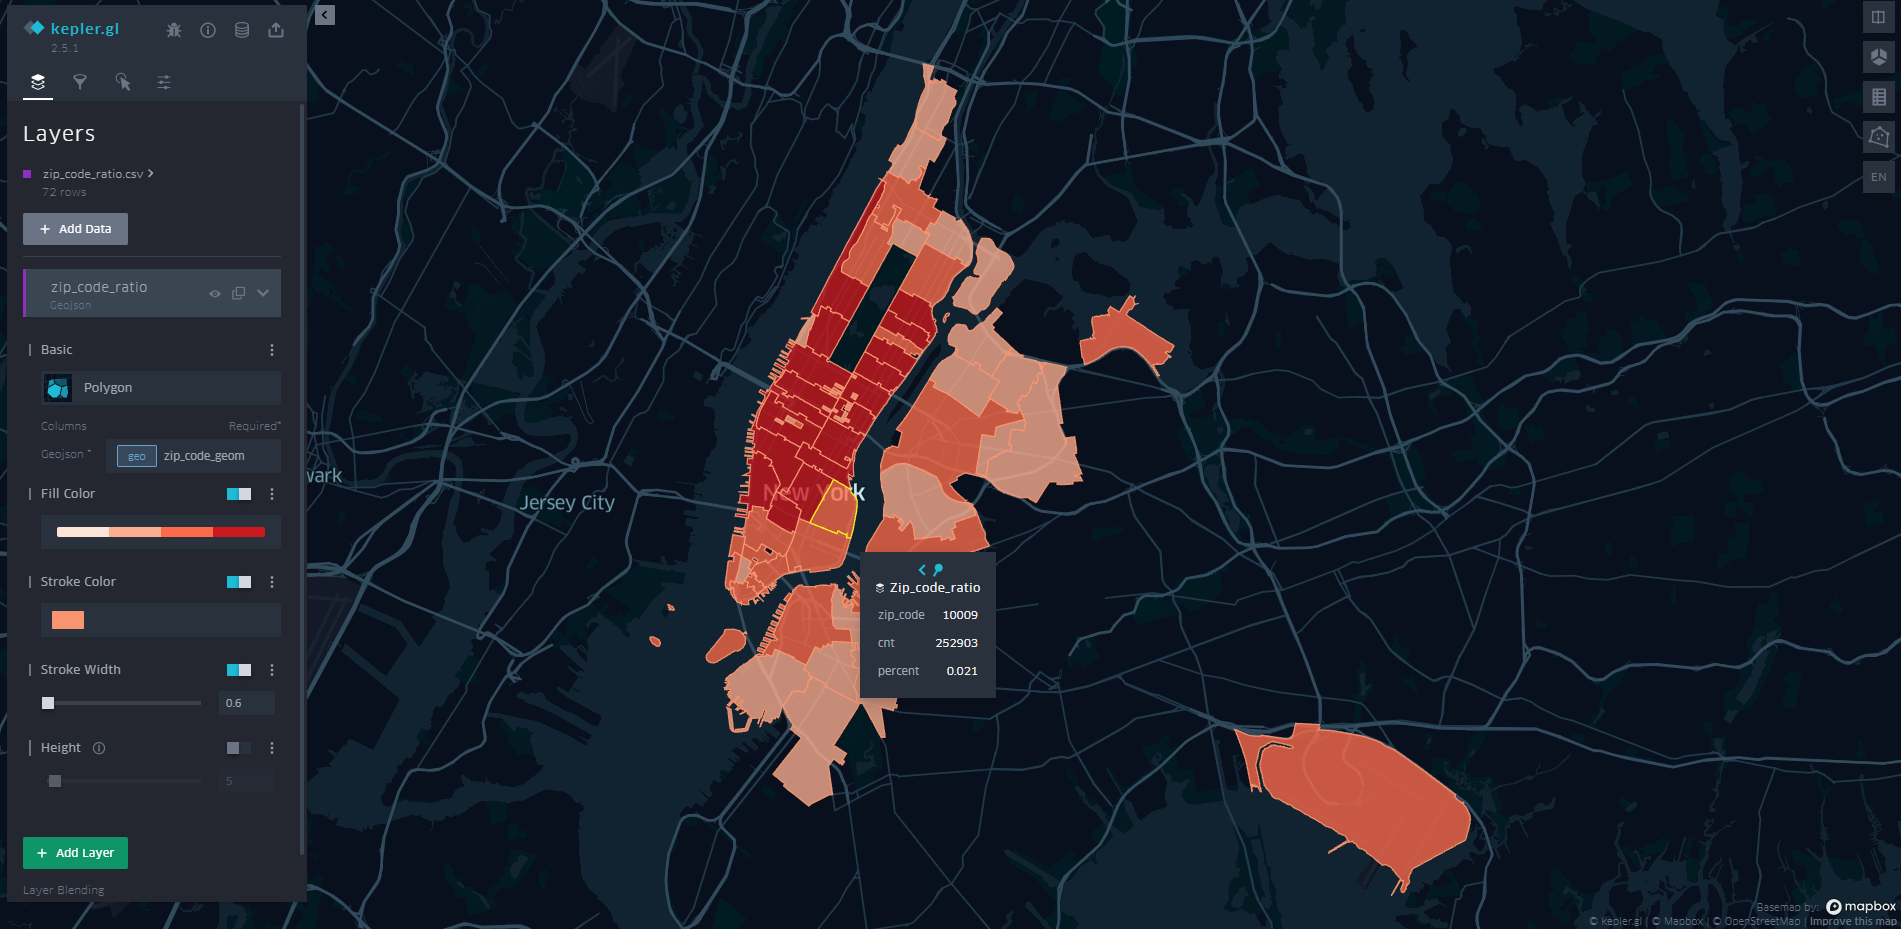

In [9]:
from IPython.display import Image
Image('kapler 시각화.png')

#### 하루 단위 zip_code별 trip box plot

In [10]:
filter_zip_code_ = filter_zip_code['zip_code'].to_list()

In [11]:
zip_df = df[['zip_code','zip_code_geom','pickup_hour','cnt']]
zip_df

,zip_code,zip_code_geom,pickup_hour,cnt
0,11369,"POLYGON((-73.887731 40.766915, -73.887675 40.7...",2015-01-01 00:00:00,14
1,10279,"POLYGON((-74.009254 40.713256, -74.009668 40.7...",2015-01-01 00:00:00,3
2,11233,"POLYGON((-73.938223 40.683894, -73.938077 40.6...",2015-01-01 00:00:00,8
3,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01 00:00:00,45
4,11235,"POLYGON((-73.970916 40.582612, -73.971134 40.5...",2015-01-01 00:00:00,1
...,...,...,...,...
87015,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",2015-01-31 23:00:00,16
87016,11101,"POLYGON((-73.96262 40.739033, -73.962609 40.73...",2015-01-31 23:00:00,110
87017,10470,"POLYGON((-73.880484 40.896803, -73.880404 40.8...",2015-01-31 23:00:00,1
87018,11219,"POLYGON((-74.012702 40.629024, -74.0125 40.628...",2015-01-31 23:00:00,1


In [12]:
zip_df['date'] = zip_df['pickup_hour'].dt.date

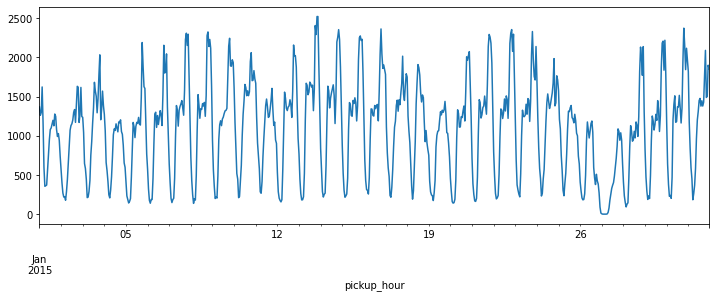

In [13]:
plt.figure(figsize=(12,4))
zip_df[zip_df['zip_code'] == '10019'].set_index('pickup_hour')['cnt'].plot()

In [20]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code_)]
filter_zip_df

,zip_code,zip_code_geom,pickup_hour,cnt,date
3,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01 00:00:00,45,2015-01-01
8,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",2015-01-01 00:00:00,26,2015-01-01
9,10170,"POLYGON((-73.977107 40.751883, -73.976048 40.7...",2015-01-01 00:00:00,44,2015-01-01
12,10154,"POLYGON((-73.973068 40.758432, -73.973524 40.7...",2015-01-01 00:00:00,12,2015-01-01
14,10021,"MULTIPOLYGON(((-73.959493 40.758974, -73.95972...",2015-01-01 00:00:00,874,2015-01-01
...,...,...,...,...,...
87013,11102,"POLYGON((-73.937858 40.774088, -73.937813 40.7...",2015-01-31 23:00:00,23,2015-01-31
87014,10172,"POLYGON((-73.974897 40.755928, -73.975352 40.7...",2015-01-31 23:00:00,11,2015-01-31
87015,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",2015-01-31 23:00:00,16,2015-01-31
87016,11101,"POLYGON((-73.96262 40.739033, -73.962609 40.73...",2015-01-31 23:00:00,110,2015-01-31


In [32]:
filter_daliy_df = filter_zip_df.groupby(['zip_code','date'])['cnt'].sum().reset_index()
filter_daliy_df

,zip_code,date,cnt
0,10001,2015-01-01,16770
1,10001,2015-01-02,17046
2,10001,2015-01-03,20478
3,10001,2015-01-04,16743
4,10001,2015-01-05,17441
...,...,...,...
2227,11430,2015-01-27,1345
2228,11430,2015-01-28,7727
2229,11430,2015-01-29,7527
2230,11430,2015-01-30,7079


In [31]:
filter_daliy_df.pivot_table('cnt', index='date', columns='zip_code').iplot(kind='box', x='zip_code')

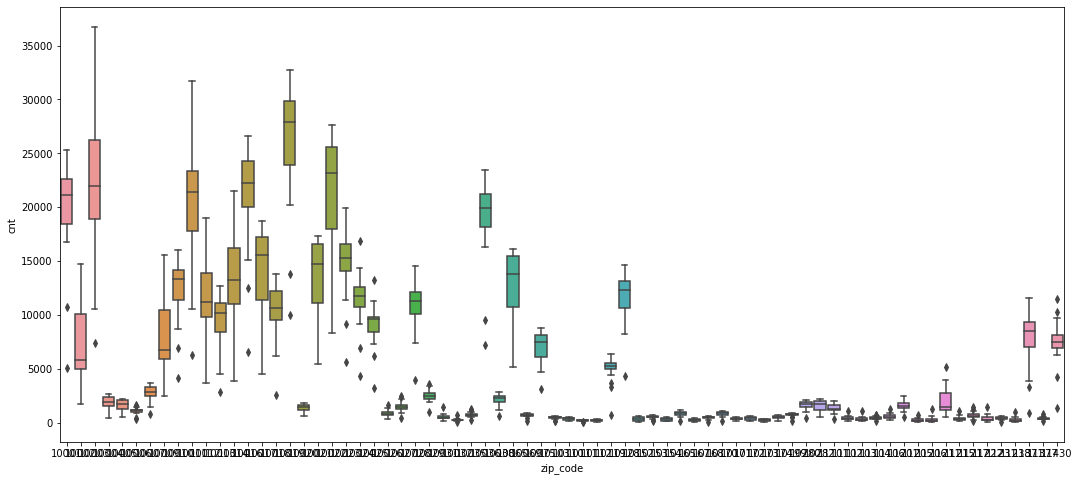

In [43]:
plt.figure(figsize=(18,8))
sns.boxplot(x='zip_code',y='cnt',data=filter_daliy_df)

In [46]:
filter_zip_df[filter_zip_df['zip_code']=='10001']

,zip_code,zip_code_geom,pickup_hour,cnt,date
74,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 00:00:00,1221,2015-01-01
298,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 01:00:00,1151,2015-01-01
460,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 02:00:00,939,2015-01-01
539,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 03:00:00,997,2015-01-01
766,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 04:00:00,794,2015-01-01
...,...,...,...,...,...
86460,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 19:00:00,1534,2015-01-31
86573,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 20:00:00,1219,2015-01-31
86747,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 21:00:00,1574,2015-01-31
86842,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 22:00:00,1385,2015-01-31


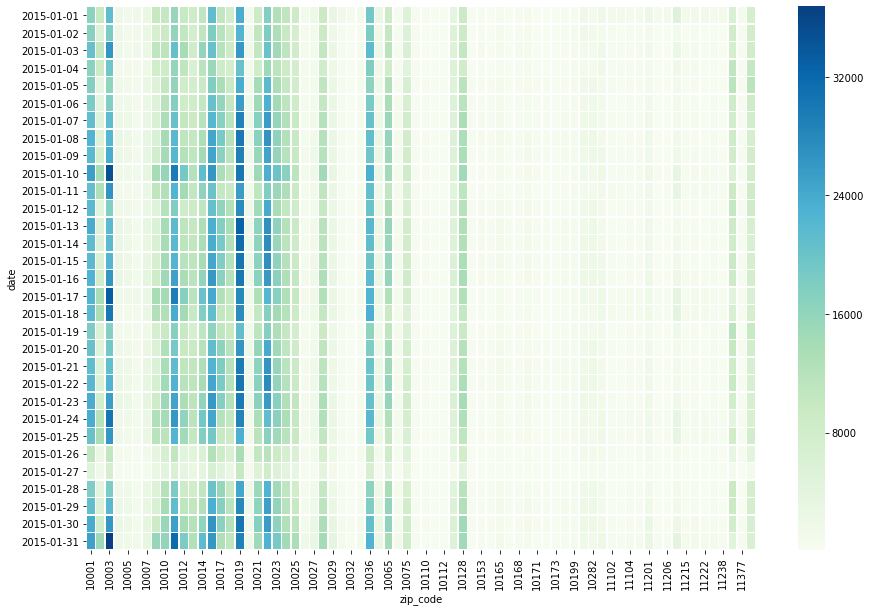

In [54]:
plt.figure(figsize=(15,10))
sns.heatmap(filter_zip_df.groupby(['date','zip_code'])['cnt'].sum().unstack(),cmap='GnBu'
            ,lw=0.5)

In [74]:
filter_zip_df['hour']=filter_zip_df['pickup_hour'].dt.hour
filter_zip_df.head()

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
3,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01,45,2015-01-01,0
8,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",2015-01-01,26,2015-01-01,0
9,10170,"POLYGON((-73.977107 40.751883, -73.976048 40.7...",2015-01-01,44,2015-01-01,0
12,10154,"POLYGON((-73.973068 40.758432, -73.973524 40.7...",2015-01-01,12,2015-01-01,0
14,10021,"MULTIPOLYGON(((-73.959493 40.758974, -73.95972...",2015-01-01,874,2015-01-01,0


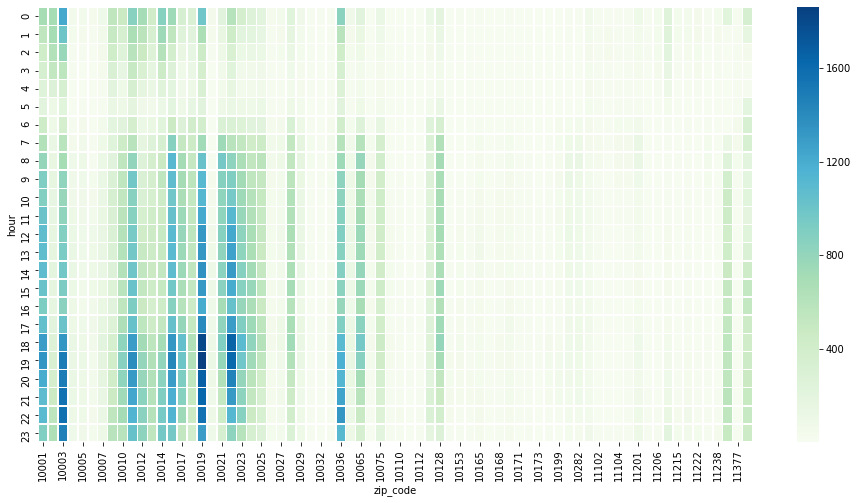

In [83]:
plt.figure(figsize=(16,8))
sns.heatmap(filter_zip_df.groupby(['hour','zip_code'])['cnt'].mean().unstack(),cmap='GnBu'
            ,lw=0.5)